# 模型训练
1. **导入DLEPS模块**：
   - 从`dleps_predictor`模块中导入`DLEPS`类，这是用于训练和预测的核心模型类。
2. **初始化DLEPS模型**：
   - 创建一个`DLEPS`类的实例`dleps_p`，用于后续的模型训练和预测。
3. **查看模型结构**：
   - 使用`summary()`方法打印模型的层次结构，有助于理解模型的组成和参数。
4. **加载数据**：
   - 使用`h5py`库从HDF5文件中加载SMILES字符串的训练和测试数据，以及对应的RNA表达数据。
5. **检查数据形状**：
   - 打印加载的数据集的形状，以确认数据的维度和大小。
6. **分割测试数据**：
   - 将测试数据集分割为两部分，一部分用于测试，另一部分用于验证，以确保模型的泛化能力。
7. **训练模型**：
   - 使用`dleps_p.train`方法训练模型，输入包括训练数据、验证数据和训练参数（如epochs、batch_size、shuffle）。

In [1]:
import sys
sys.path.append('/mnt/d/Research/PHD/DLEPS/code/DLEPS')
from dleps_predictor import DLEPS

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Using TensorFlow backend.


In [2]:
# 初始化DLEPS模型，不指定模型权重路径
dleps_p = DLEPS()

2024-12-09 13:58:52.186926: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2024-12-09 13:58:52.311781: E tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:969] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-09 13:58:52.311809: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: NVIDIA GeForce RTX 4090 major: 8 minor: 9 memoryClockRate(GHz): 2.52
pciBusID: 0000:01:00.0
2024-12-09 13:58:52.311870: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcudart.so.10.0'; dlerror: libcudart.so.10.0: cannot open shared object file: No such file or directory
2024-12-09 13:58:52.311897: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcublas.so.10.0'; dlerror: libcublas.so.10.0: cannot open shar

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
DLEPS: No input of up files

DLEPS: No input of down files

Model weights not found. Please train the model or provide model weights.


In [3]:
# 查看模型结构
dleps_p.model[0].summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 277, 76)      0                                            
__________________________________________________________________________________________________
conv_1 (Conv1D)                 (None, 269, 9)       6165        input_4[0][0]                    
__________________________________________________________________________________________________
conv_2 (Conv1D)                 (None, 261, 9)       738         conv_1[0][0]                     
__________________________________________________________________________________________________
conv_3 (Conv1D)                 (None, 251, 10)      1000        conv_2[0][0]                     
____________________________________________________________________________________________

In [4]:
# 加载SMILES训练和测试数据
import h5py
h5f = h5py.File('/mnt/d/Research/PHD/DLEPS/results/SMILE_train_demo.h5', 'r')
smile_train = h5f['data'][:]
h5f.close()

h5f2 = h5py.File('/mnt/d/Research/PHD/DLEPS/results/SMILE_test_demo.h5', 'r')
smile_test = h5f2['data'][:]
h5f2.close()

# 加载RNA训练和测试数据
h5f3 = h5py.File('/mnt/d/Research/PHD/DLEPS/results/L1000_train.h5', 'r')
rna_train = h5f3['data'][:]
h5f3.close()

h5f4 = h5py.File('/mnt/d/Research/PHD/DLEPS/results/L1000_test.h5', 'r')
rna_test = h5f4['data'][:]
h5f4.close()


In [5]:
# 检查数据形状
print("smile_train.shape:", smile_train.shape)
print("smile_test.shape:", smile_test.shape)
print("rna_train.shape:", rna_train.shape)
print("rna_test.shape:", rna_test.shape)

smile_train.shape: (5928, 277, 76)
smile_test.shape: (3000, 277, 76)
rna_train.shape: (5928, 978)
rna_test.shape: (3000, 978)


In [6]:
# 分割测试数据用于验证集
sz = int(smile_test.shape[0] / 2)
rna_val = rna_test[sz:]
rna_test = rna_test[:sz]
smile_val = smile_test[sz:]
smile_test = smile_test[:sz]

In [7]:
# 训练模型
his = dleps_p.train(smile_train, rna_train, (smile_val, rna_val), epochs=100, batch_size=64, shuffle=True)
# 模型训练完成后，模型权重已保存在 'my_trained_model.h5'


Train on 5928 samples, validate on 1500 samples
Epoch 1/100
5928/5928 [==============================] - 2s 314us/step - loss: 0.2259 - val_loss: 0.2005
Epoch 2/100
5928/5928 [==============================] - 2s 259us/step - loss: 0.2108 - val_loss: 0.1981
Epoch 3/100
5928/5928 [==============================] - 2s 257us/step - loss: 0.2090 - val_loss: 0.1978
Epoch 4/100
5928/5928 [==============================] - 2s 262us/step - loss: 0.2083 - val_loss: 0.1978
Epoch 5/100
5928/5928 [==============================] - 2s 254us/step - loss: 0.2079 - val_loss: 0.1978
Epoch 6/100
5928/5928 [==============================] - 2s 257us/step - loss: 0.2076 - val_loss: 0.1976
Epoch 7/100
5928/5928 [==============================] - 2s 262us/step - loss: 0.2074 - val_loss: 0.1976
Epoch 8/100
5928/5928 [==============================] - 2s 259us/step - loss: 0.2072 - val_loss: 0.1976
Epoch 9/100
5928/5928 [==============================] - 1s 251us/step - loss: 0.2070 - val_loss: 0.1975
Epoch 

# 模型评估
1. **预测和评估训练集**：
   - 对训练集进行预测，并计算预测值和实际RNA表达之间的相关系数，以评估模型的性能。
   - 绘制相关系数的直方图，并计算平均相关系数。
   - 可视化部分训练集样本的预测结果和实际RNA表达。
2. **分析和可视化测试集**：
   - 对测试集进行预测，并重复训练集的分析和可视化步骤，以评估模型在未见数据上的表现。

In [8]:
# 预测训练集并计算相关性
import matplotlib.pyplot as plt
import numpy as np

In [9]:
# 计算训练集预测值
y_pred = dleps_p.model[0].predict(smile_train)

In [10]:
# 计算相关系数
corr = []
print("smile_train.shape:", smile_train.shape)
print("y_pred.shape:", y_pred.shape)
for i in range(smile_train.shape[0]):
    corr.append(np.corrcoef(rna_train[i], y_pred[i])[0, 1])

smile_train.shape: (5928, 277, 76)
y_pred.shape: (5928, 978)


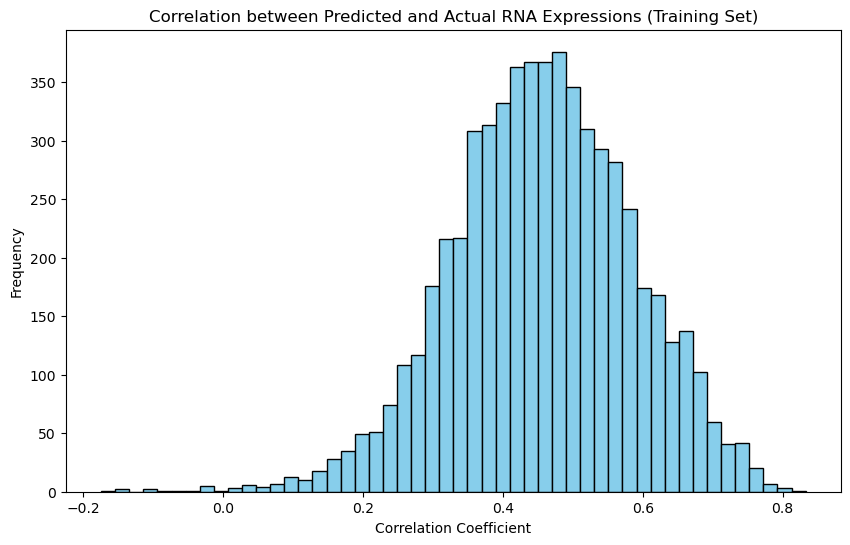

Mean correlation (Training set): 0.4562323683566604


In [11]:
# 绘制相关系数的直方图
plt.figure(figsize=(10, 6))
plt.hist(corr, bins=50, color='skyblue', edgecolor='black')
plt.title('Correlation between Predicted and Actual RNA Expressions (Training Set)')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Frequency')
plt.show()
print("Mean correlation (Training set):", np.mean(corr))

In [12]:
# 定义密度计算函数
from scipy.stats import gaussian_kde

In [13]:
def density(x, y):
    xy = np.vstack([x, y])
    return gaussian_kde(xy)(xy)

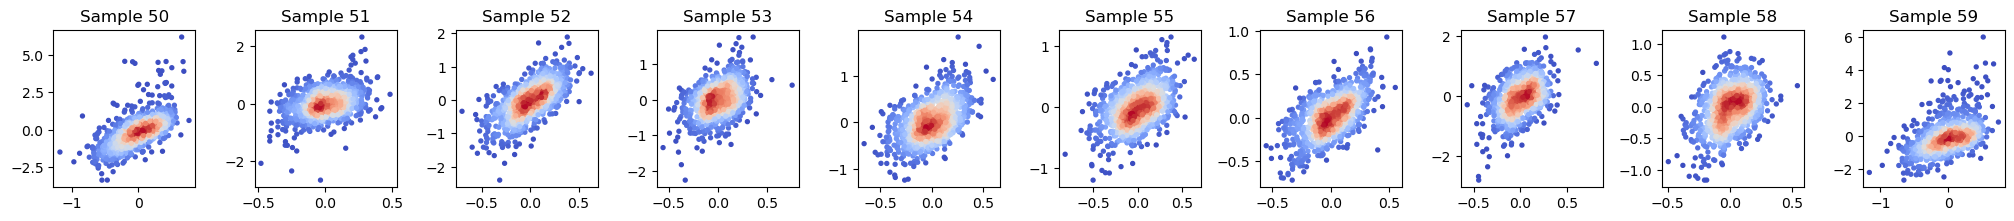

In [14]:
# 可视化训练集样本
n = 10  # 展示样本数量
sam = 50
plt.figure(figsize=(20, 6))
# 使用默认样式
for i in range(n):
    ax = plt.subplot(3, n, i + 1)
    plt.scatter(y_pred[sam + i], rna_train[sam + i],
                c=density(y_pred[sam + i], rna_train[sam + i]),
                s=8, cmap="coolwarm")
    plt.title(f'Sample {sam + i}')
plt.tight_layout()
plt.show()

In [15]:
# 分析测试集
y_pred2 = dleps_p.model[0].predict(smile_test)

In [16]:
corr = []
print("smile_test.shape:", smile_test.shape)
print("y_pred2.shape:", y_pred2.shape)
for i in range(smile_test.shape[0]):
    corr.append(np.corrcoef(rna_test[i], y_pred2[i])[0, 1])


smile_test.shape: (1500, 277, 76)
y_pred2.shape: (1500, 978)


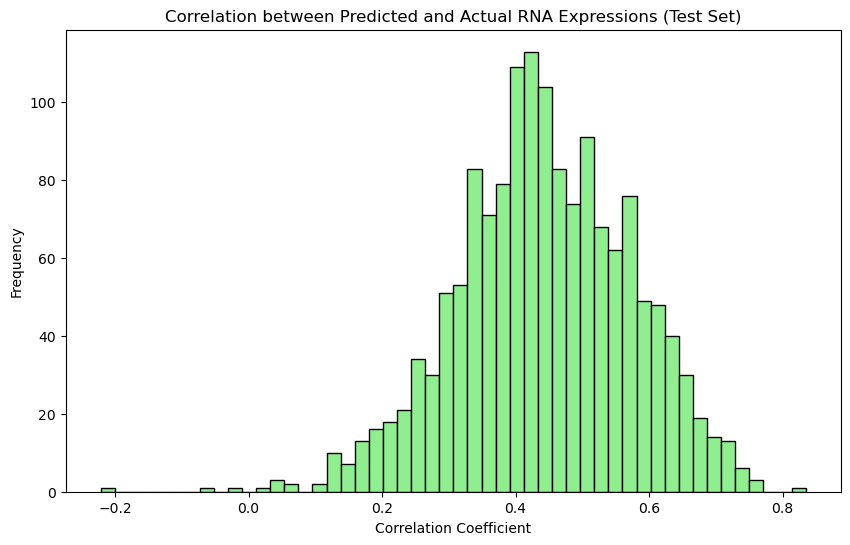

Mean correlation (Test set): 0.44243255841492585


In [17]:
# 绘制测试集相关系数的直方图
plt.figure(figsize=(10, 6))
plt.hist(corr, bins=50, color='lightgreen', edgecolor='black')
plt.title('Correlation between Predicted and Actual RNA Expressions (Test Set)')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Frequency')
plt.show()
print("Mean correlation (Test set):", np.mean(corr))


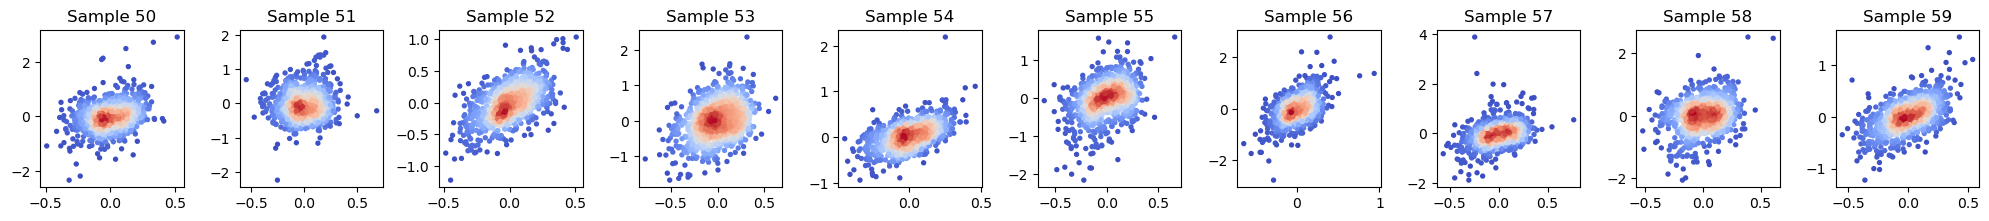

In [18]:
# 可视化测试集样本
n = 10  # 展示样本数量
sam = 50
plt.figure(figsize=(20, 6))
# 使用默认样式
for i in range(n):
    ax = plt.subplot(3, n, i + 1)
    plt.scatter(y_pred2[sam + i], rna_test[sam + i],
                c=density(y_pred2[sam + i], rna_test[sam + i]),
                s=8, cmap="coolwarm")
    plt.title(f'Sample {sam + i}')
plt.tight_layout()
plt.show()
